# Introduction

In the following notebook, I will be performing an EDA of processed Reviews Data to get a better understanding of positive and negative reviews before finally moving onto modelling.

**Import libraries**

In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

**Set notebook preferences**

In [150]:
#Set pandas preferences
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 200)

#Set plot style
plt.style.use('Solarize_Light2')
print(plt.style.available)

#Surpress warnings
warnings.filterwarnings('ignore')

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


**Read in data**

In [151]:
#Set path
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python\In Progress\Airbnb - San Francisco\Data\03_Processed'

#Read in data
df = pd.read_csv(path + '/2020_0616_Reviews_Processed.csv', index_col=0)

# #Remove brackets
# df['tokens_clean'] = df['tokens_clean'].replace(r'[\[\]]',' ', regex = True)


**Preview data**

In [152]:
print('Data shape:', df.shape)
df.head()

Data shape: (36753, 9)


,comments,review_scores_rating,language,comments_normalized,tokens_raw,tokens_clean,tokens_clean_pos,comments_word_count,review_label
7790,Paul has a super nice place and is a super nice guy. The apartment is extremely clean and has an excellent location nestled between the Mission and Noe Valley. Definitely recommend his apartment!,100.0,en,paul has a super nice place and is a super nice guy the apartment is extremely clean and has an excellent location nestled between the mission and noe valley definitely recommend his apartment,paul has a super nice place and is a super nice guy the apartment is extremely clean and has an excellent location nestled between the mission and noe valley definitely recommend his apartment,"['paul', 'super', 'nice', 'place', 'super', 'nice', 'guy', 'apartment', 'extremely', 'clean', 'excellent', 'location', 'nestle', 'mission', 'noe', 'valley', 'definitely', 'recommend', 'apartment']","[('paul', 'NN'), ('super', 'NN'), ('nice', 'JJ'), ('place', 'NN'), ('super', 'JJ'), ('nice', 'JJ'), ('guy', 'NN'), ('apartment', 'NN'), ('extremely', 'RB'), ('clean', 'JJ'), ('excellent', 'JJ'), ('location', 'NN'), ('nestle', 'JJ'), ('mission', 'NN'), ('noe', 'FW'), ('valley', 'NN'), ('definitely', 'RB'), ('recommend', 'JJ'), ('apartment', 'NN')]",33,great
10317,Did not stay here. There was a challenge that was not resolved. Inflexible personality. I asked for and Lawrence refused to refund anything.. Mumbled under his breath how 'rediculous' we were.,20.0,en,did not stay here there was a challenge that was not resolved inflexible personality i asked for and lawrence refused to refund anything mumbled under his breath how rediculous we were,did not stay here there was a challenge that was not resolved inflexible personality i asked for and lawrence refused to refund anything mumbled under his breath how rediculous we were,"['stay', 'challenge', 'resolve', 'inflexible', 'personality', 'ask', 'lawrence', 'refuse', 'refund', 'mumble', 'breath', 'rediculous']","[('stay', 'NN'), ('challenge', 'NN'), ('resolve', 'VBP'), ('inflexible', 'JJ'), ('personality', 'NN'), ('ask', 'NN'), ('lawrence', 'NN'), ('refuse', 'NN'), ('refund', 'NN'), ('mumble', 'JJ'), ('breath', 'NN'), ('rediculous', 'JJ')]",32,poor
12146,"He's great. Location is perfect, especially if you have a bicycle.",60.0,en,he s great location is perfect especially if you have a bicycle,he s great location is perfect especially if you have a bicycle,"['great', 'location', 'perfect', 'especially', 'bicycle']","[('great', 'JJ'), ('location', 'NN'), ('perfect', 'NN'), ('especially', 'RB'), ('bicycle', 'VB')]",11,poor
27172,"Rebecca's studio is great. I felt completely at home with all the comforts and amenities that one could expect. Both the building and studio are very clean, modern and convenient to public transportation and San Francisco. Rebecca was very helpful and accommodating. I'd stay at her place again and would recommend anyone visiting SF to consider it as an excellent alternative to a hotel, especially if you prefer a modern accommodation.",80.0,en,rebecca s studio is great i felt completely at home with all the comforts and amenities that one could expect both the building and studio are very clean modern and convenient to public transportation and san francisco rebecca was very helpful and accommodating i d stay at her place again and would recommend anyone visiting sf to consider it as an excellent alternative to a hotel especially if you prefer a modern accommodation,rebecca s studio is great i felt completely at home with all the comforts and amenities that one could expect both the building and studio are very clean modern and convenient to public transportation and san francisco rebecca was very helpful and accommodating i d stay at her place again and would recommend anyone visiting sf to consider it as an excellent alternative to a hotel especially if you prefer a modern accommodation,"['rebecca', 'studio', 'great', 'feel', 'completely', 'home'

**Data Types and General Data Metrics**

In [153]:
print(df.info())
print('\nData Metrics:\n{}\nVariance:\n{}'.format(df.describe(),df.var()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36753 entries, 7790 to 513317
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comments              36753 non-null  object 
 1   review_scores_rating  36753 non-null  float64
 2   language              36753 non-null  object 
 3   comments_normalized   36753 non-null  object 
 4   tokens_raw            36753 non-null  object 
 5   tokens_clean          36753 non-null  object 
 6   tokens_clean_pos      36753 non-null  object 
 7   comments_word_count   36753 non-null  int64  
 8   review_label          36753 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 2.8+ MB
None

Data Metrics:
       review_scores_rating  comments_word_count
count          36753.000000         36753.000000
mean              96.100590            44.897668
std                5.579527            48.036226
min               20.000000             1.000000


# Exploratory Data Analysis

### Reveiw Scores Distributions

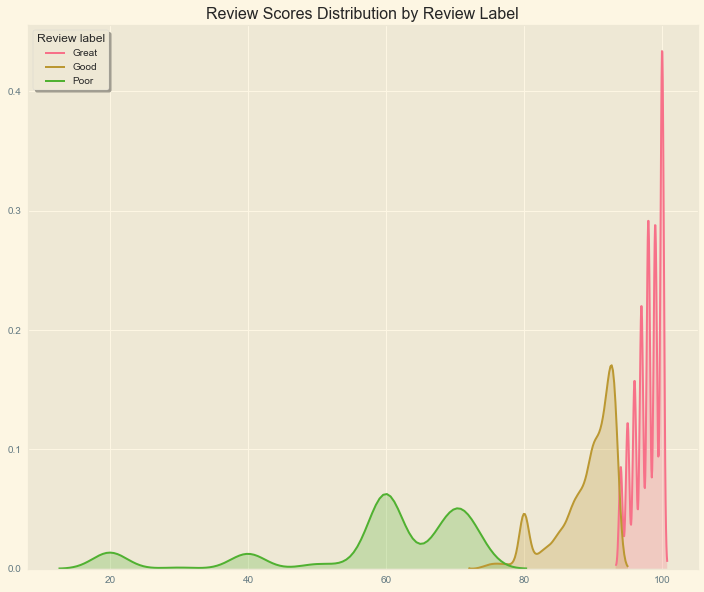

In [154]:
#Set figure
f, ax = plt.subplots(figsize = (12,10))

colors = sns.set_palette("husl")
g = sns.FacetGrid(df, hue="review_label", hue_order=['great','good','poor'])
g.map(sns.kdeplot, "review_scores_rating",shade = True,ax=ax,color=colors)

###Set plot Aesthetics###
#Title
ax.set_title('Review Scores Distribution by Review Label')

#Legend
ax.legend(title ='Review label',labels = ['Great','Good','Poor'], shadow = True, frameon = True)

#Close extra plot
plt.close();

**Word Lengths for Great, good, and poor reviews**

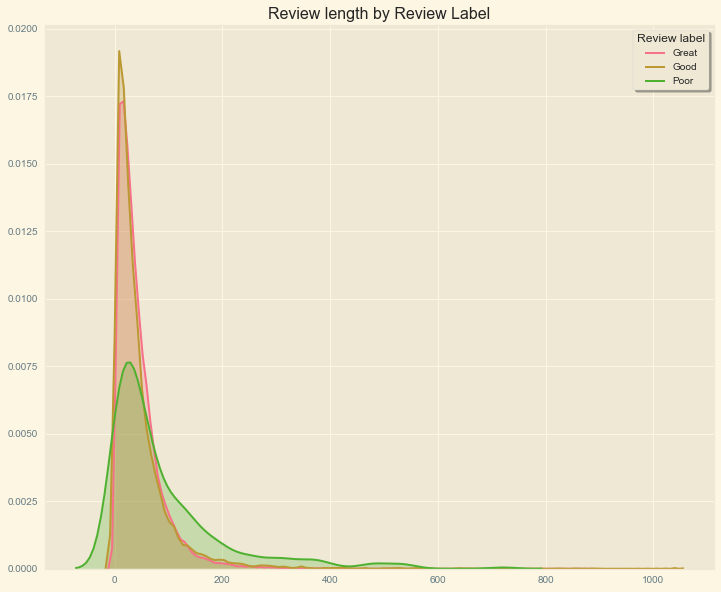

In [155]:
#Set figure
f, ax = plt.subplots(figsize = (12,10))

g = sns.FacetGrid(df, hue="review_label", hue_order=['great','good','poor'])
g.map(sns.kdeplot, "comments_word_count",shade = True,ax=ax,color=colors)

###Set plot Aesthetics###
#Title
ax.set_title('Review length by Review Label')

#Legend
ax.legend(title ='Review label',labels = ['Great','Good','Poor'], shadow = True, frameon = True)

#Close extra plot
plt.close();

# Words

Data Preparation

In [156]:
#Prepare data
positive_reviews = df.loc[df.review_label == 'great']
negative_reviews = df.loc[df.review_label == 'poor']

#Remove quotes around tokens for cleaner viz
positive_reviews[['tokens_clean','tokens_clean_pos']] = positive_reviews[['tokens_clean','tokens_clean_pos']].replace(r'[\']','', regex = True)
negative_reviews[['tokens_clean','tokens_clean_pos']] = negative_reviews[['tokens_clean','tokens_clean_pos']].replace(r'[\']','', regex = True)

**Word Frequency**

In [157]:
#Import libraries for word count visualization
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text.freqdist import FreqDistVisualizer



#Init CountVectorizer
vectorizer = CountVectorizer()

#
positive_docs =vectorizer.fit_transform(positive_reviews.tokens_clean)
positive_features = vectorizer.get_feature_names()

negative_docs =vectorizer.fit_transform(negative_reviews.tokens_clean)
negative_features = vectorizer.get_feature_names()

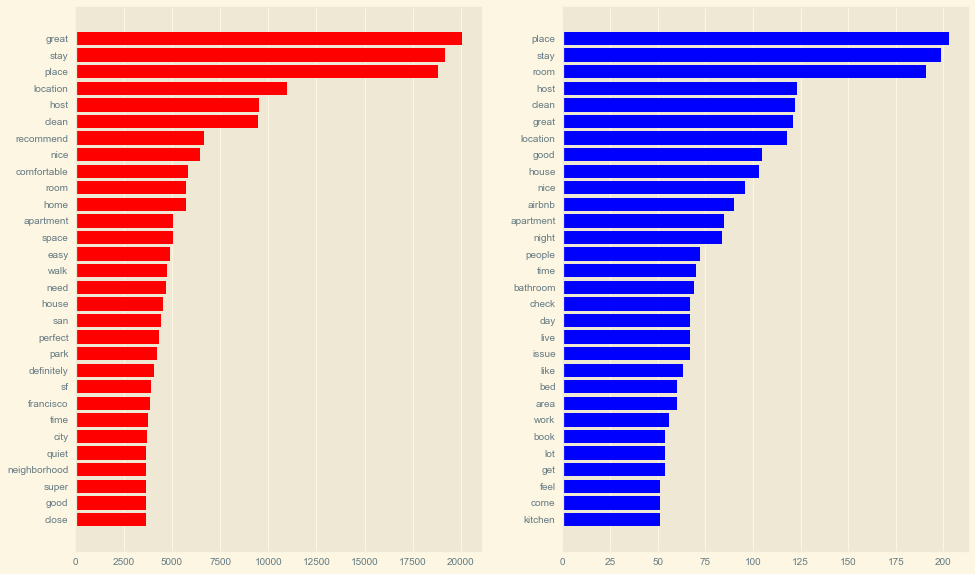

In [158]:
f,ax = plt.subplots(1,2, figsize=(16,10))

visualizer = FreqDistVisualizer(features=positive_features, n=30, orient='h', color = 'red',ax = ax[0])
visualizer.fit(positive_docs)
visualizer.poof;

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=negative_features, n=30, orient='h', color = 'blue', ax = ax[1])
visualizer.fit(negative_docs)
visualizer.poof;

**Word Cloud**

Text(0.5, 1.0, 'Negative Comments\n')

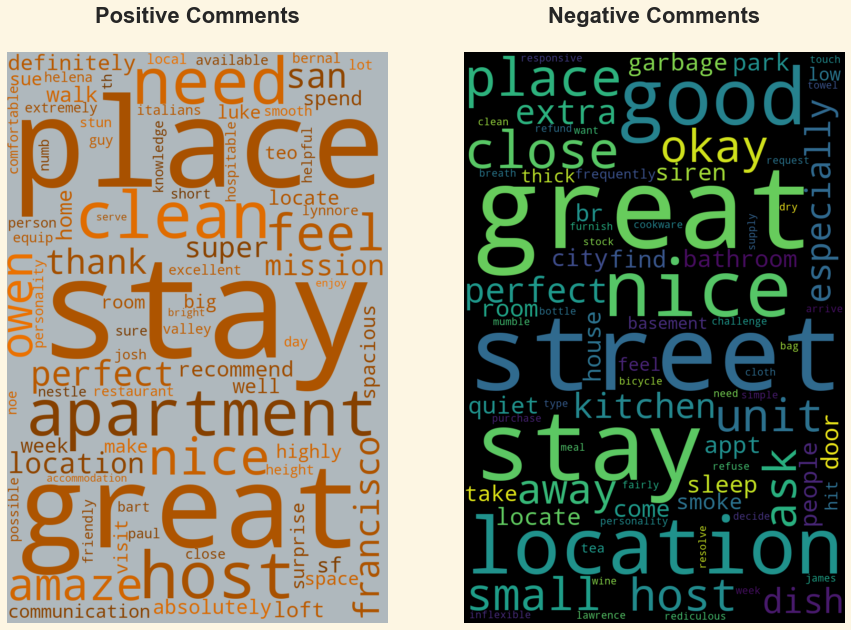

In [159]:
#Function that generates color font for wordcloud(from the internet somewhere)
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 21.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)


#Import wordcloud libraries 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

positive_wordcloud = WordCloud( width=800,max_words=80,
    min_font_size=10,collocations=False,background_color='#AFB8BD', color_func=random_color_func,
    height=1200,).generate(str(positive_reviews['tokens_clean']))
    
negative_wordcloud = WordCloud( width=800,max_words=80,
    min_font_size=10, collocations=False,background_color='black',
    height=1200,).generate(str(negative_reviews['tokens_clean']))

#Plot data and set plot aesthetics
f,ax = plt.subplots(1,2,figsize = (15,15))
ax[0].imshow(positive_wordcloud, interpolation = 'bilinear')
ax[0].axis("off")
ax[0].set_title('Positive Comments\n', fontsize=22, fontweight='semibold')


#Plot data and set plot aesthetics
ax[1].imshow(negative_wordcloud, interpolation = 'bilinear')
ax[1].axis("off")
ax[1].set_title('Negative Comments\n', fontsize=22, fontweight='semibold')

**Topc Modeling**

In [169]:
#Read in libraries
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

In [164]:
#Convert df.tokens_clean into a list of lists of tokens
tokens = list(df.tokens_clean)

#Check
print(tokens[6])

['italians', 'stay', 'josh', 'loft', 'day', 'hospitable', 'available', 'loft', 'equip', 'need', 'comfortable']


In [ ]:
#Create word mapping to id dictionary
dictionary = corpora.Dictionary(tokens)

#Convert each document in tokens into a BoW
corpus = [dictionary.doc2bow(token) for token in tokens]

LDA Model

In [ ]:
from gensim.models.ldamodel import LdaModel

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word = dictionary)

Coherence score

In [ ]:
from gensim.models.coherencemodel import CoherenceModel


# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)